# Description

This Python script loads a trained model and a dataset to perform fraud detection. It provides functions to select a specific row for prediction, make predictions with the loaded model, evaluate the model on the entire dataset, and display feature importance. The script uses libraries such as pandas, numpy, joblib, matplotlib, and seaborn.

## Summary of Functions:

* load_data(file_path): Loads a CSV file into a DataFrame.
* select_row(df, fraud=True): Selects the first fraudulent or non-fraudulent row from the DataFrame.
* predict_row(loaded_model, row): Predicts the fraud status of the given row using the loaded model.
* display_prediction(pred_dict, prediction, prediction_proba): Displays the prediction results and input features.
* evaluate_model(loaded_model, df): Evaluates the model on the entire dataset and displays accuracy, classification report, and confusion matrix.
* get_feature_names(column_transformer): Retrieves feature names from a ColumnTransformer.
* display_feature_importance(loaded_model, top_n=20): Displays the top N most important features of the model.

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def select_row(df, fraud=True):
    if fraud:
        selected_row = df[df["Is Fraud?"] == 1].iloc[[0]]  # Select first fraudulent row
    else:
        selected_row = df[df["Is Fraud?"] == 0].iloc[[0]]  # Select first non-fraudulent row
    return selected_row

In [3]:
def predict_row(loaded_model, row):
    # Drop the target column from the selected row
    x = row.drop(columns=["Is Fraud?"])

    # Predict using the loaded model
    prediction = loaded_model.predict(x)
    prediction_proba = loaded_model.predict_proba(x)

    # Create a dictionary from the selected row
    pred_dict = x.iloc[0].to_dict()

    return pred_dict, prediction[0], prediction_proba[0]

In [4]:
def display_prediction(pred_dict, prediction, prediction_proba):
    # Print the dictionary items
    for key, value in pred_dict.items():
        print(f"{key}: {value}")

    # Print the prediction and probabilities
    print(f"Prediction: {prediction}")
    print(f"Prediction Probabilities: {prediction_proba}")

In [5]:
def evaluate_model(loaded_model, df):
    X = df.drop(columns=["Is Fraud?"])
    y = df["Is Fraud?"]

    y_pred = loaded_model.predict(X)
    y_pred_proba = loaded_model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred)
    cm = confusion_matrix(y, y_pred)

    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers in the ColumnTransformer"""
    output_features = []

    for name, transformer, features in column_transformer.transformers_:
        if transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            output_features.extend(transformer.get_feature_names_out(features))
        elif hasattr(transformer, 'get_feature_names'):
            output_features.extend(transformer.get_feature_names())
        else:
            output_features.extend(features)

    return output_features

def display_feature_importance(loaded_model, top_n=20):
    # If the model is a pipeline, extract the final model and the preprocessor
    if hasattr(loaded_model, 'named_steps'):
        model = loaded_model.named_steps['classifier']
        preprocessor = loaded_model.named_steps['preprocessor']
    else:
        model = loaded_model
        preprocessor = None

    # Get feature names from preprocessor if available
    if preprocessor is not None:
        preprocessor.fit(df.drop(columns=["Is Fraud?"]))  # Ensure the preprocessor is fitted
        feature_names = get_feature_names(preprocessor)
    else:
        feature_names = [f"Feature {i}" for i in range(len(model.feature_importances_))]

    # Check if the model has feature_importances_ attribute
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        
        sorted_idx = np.argsort(feature_importances)[-top_n:]  # Select top_n features
        plt.figure(figsize=(10, 7))
        plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_n} Feature Importances')
        plt.show()
    else:
        print("The model does not have feature_importances_ attribute.")


In [7]:
# Load your data
df = pd.read_csv('data/final_merged_100users.csv')

In [8]:
# Load your trained model
loaded_model = joblib.load('trained_model100_xgboost.joblib')

In [9]:
# Select a row for prediction (fraudulent or non-fraudulent)
row = select_row(df, fraud=True)

In [10]:
# Predict and display the results
pred_dict, prediction, prediction_proba = predict_row(loaded_model, row)
display_prediction(pred_dict, prediction, prediction_proba)

Amount: 287.13
Use Chip: Online Transaction
Merchant State: Online Transaction
Errors?: No Error
Per Capita Income - Zipcode: 29278
Yearly Income - Person: 59696
Total Debt: 127613
FICO Score: 787
Num Credit Cards: 5
Has Chip: 1
Cards Issued: 2
International: 0
Online: 1
Age_at_transaction: 49
income_to_debt: 0.4677893281422008
day_of_week: 6
time_of_day: Afternoon
distances: 0.0
Prediction: 1
Prediction Probabilities: [0.00451428 0.9954857 ]


Accuracy: 0.9181653906707599
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1202369
           1       0.01      0.98      0.02      1266

    accuracy                           0.92   1203635
   macro avg       0.51      0.95      0.49   1203635
weighted avg       1.00      0.92      0.96   1203635



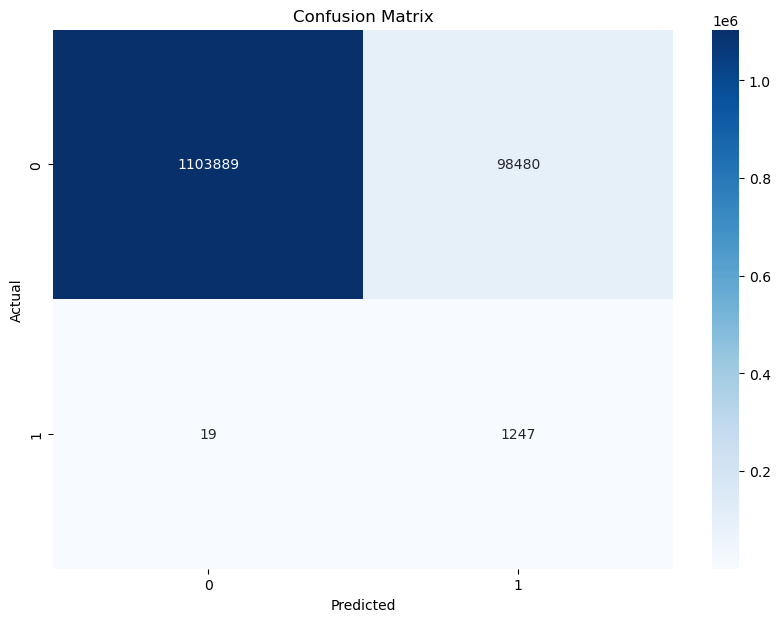

In [11]:
# Evaluate the model on the entire dataset
evaluate_model(loaded_model, df)

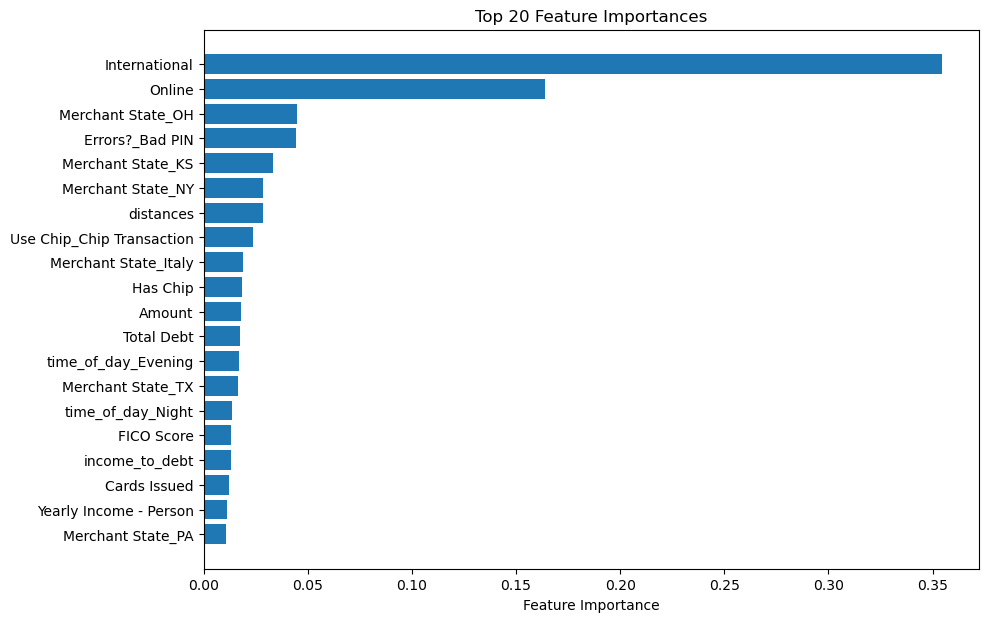

In [12]:
# Display feature importance
display_feature_importance(loaded_model)